# Unsupervised Learning 

In [1]:
%matplotlib inline 

import pandas as pd 
import numpy as np 

import matplotlib.pyplot as plt
import seaborn as sns

In [17]:
from sklearn.cluster import KMeans, MiniBatchKMeans, DBSCAN
from sklearn.mixture import GaussianMixture, BayesianGaussianMixture
from sklearn.linear_model import LogisticRegression

from sklearn.metrics import silhouette_samples
from matplotlib.ticker import FixedLocator, FixedFormatter

from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, GridSearchCV

In [71]:
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

## Data Load 

In [2]:
train = pd.read_csv("fashion-mnist_train.csv")
test  = pd.read_csv("fashion-mnist_test.csv")

In [4]:
# 0, 1, 3, 6에 해당되는 자료만을 선택
index = [0,1,3,6]

In [104]:
df_train = train.loc[train["label"].isin(index)].reset_index(drop=True)
df_test  = test.loc[test["label"].isin(index)].reset_index(drop=True)

In [105]:
df_train.shape, df_test.shape

((24000, 785), (4000, 785))

In [107]:
X_train = df_train.drop('label', axis=1)
X_test  = df_test.drop('label', axis=1)

y_train = df_train.label 
y_test  = df_test.label

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((24000, 784), (4000, 784), (24000,), (4000,))

In [141]:
# image scaling 
X_train = X_train / 255 
X_test = X_test / 255 

## 1. K Means Clustering 

### 1) 군집 수 지정 

In [142]:
k = 4
kmeans = KMeans(n_clusters=k, random_state=42)
y_pred = kmeans.fit_predict(X_train)

In [143]:
kmeans.score(X_train)   # - inertia

-712191.9477758366

In [144]:
kmeans.cluster_centers_

array([[ 2.21922632e-19,  3.20856080e-18, -3.75405002e-17, ...,
         2.73218947e-17,  6.39679282e-18,  1.29833210e-17],
       [ 1.63323080e-05,  4.89969241e-05,  3.84716589e-04, ...,
         1.61508379e-04,  4.05283199e-05,  1.69372083e-05],
       [ 8.52779757e-06,  2.86290347e-05,  3.11873740e-04, ...,
         2.93965365e-03,  8.87500076e-04,  9.19783881e-05],
       [ 3.91113892e-06,  5.99707968e-05,  3.32446809e-04, ...,
         1.73080935e-02,  3.73644139e-03,  6.74019608e-04]])

In [145]:
y_pred

array([3, 1, 1, ..., 3, 1, 2], dtype=int32)

In [146]:
# confusion matrix 
pd.crosstab(y_pred, y_train, rownames=['Predicted'], colnames=['Actual'], margins=True)

Actual,0,1,3,6,All
Predicted,,,,,
0,143,5085,2800,43,8071
1,3538,232,1613,1100,6483
2,2014,605,1475,2344,6438
3,305,78,112,2513,3008
All,6000,6000,6000,6000,24000


In [147]:
# accuracy
cm = pd.crosstab(y_pred, y_train, rownames=['Predicted'], colnames=['Actual'], margins=True)
accuracy = (cm[0][0] + cm[1][1] + cm[3][2] + cm[6][3]) / 24000 ; accuracy

0.18179166666666666

In [148]:
# 군집으로 나누어진 데이터 시각화 
def viz_img(y_pred, n):
    fig = plt.figure(1)
    box_index = 1
    for cluster in range(n):
        result = np.where(y_pred == cluster)
        for i in np.random.choice(result[0].tolist(), 10, replace=False):
            ax = fig.add_subplot(n, 10, box_index)
            plt.imshow(X_train.loc[i].values.reshape(28, 28))
            plt.gray()
            ax.get_xaxis().set_visible(False)
            ax.get_yaxis().set_visible(False)
            box_index += 1
    plt.show()

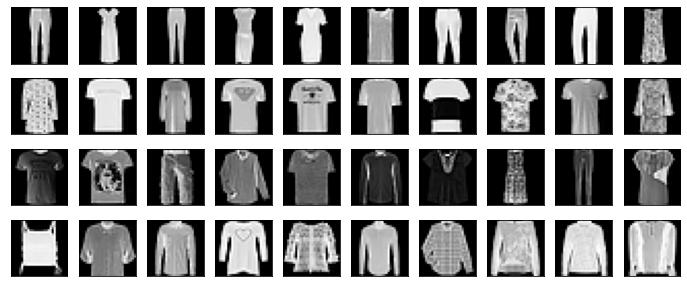

In [149]:
plt.figure(figsize=(12, 5))
viz_img(y_pred, 4)

* 군집으로 나눈 결과를 시각화 해 보면 다음과 같습니다. 
* 3개의 군집에 모두 상의가 대부분인 것으로 보아 정확도가 많이 떨어지는 것 같습니다. 

### 2) 최적의 군집 수 찾기 

In [150]:
kmeans_per_k = [KMeans(n_clusters=k, random_state=42).fit(X_train) for k in range(1, 10)]
inertias = [model.inertia_ for model in kmeans_per_k]

In [151]:
inertias

[1161739.9274040097,
 900334.8264081178,
 782824.6133949967,
 712191.9477758362,
 668201.8732475424,
 638224.3010202058,
 613145.2327656342,
 596304.4491500986,
 580621.8466573003]

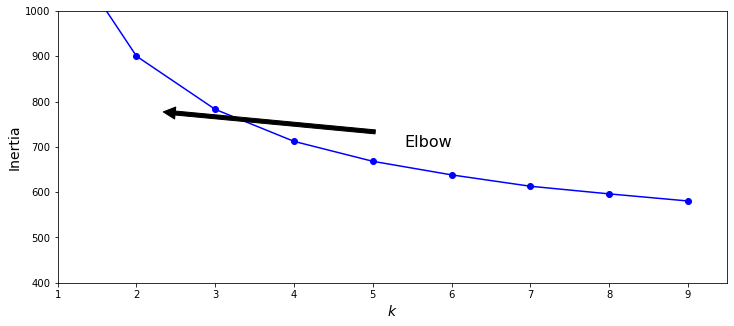

In [199]:
plt.figure(figsize=(12, 5))
plt.plot(range(1, 10), [i/1000 for i in inertias], "bo-")

plt.xlabel("$k$", fontsize=14)
plt.ylabel("Inertia", fontsize=14)

plt.annotate('Elbow',
             xy=(2, [i/1000 for i in inertias][2]),
             xytext=(0.55, 0.55),
             textcoords='figure fraction',
             fontsize=16,
             arrowprops=dict(facecolor='black', shrink=0.1)
             )

plt.axis([1, 9.5, 400, 1000])
plt.show()

* k=2 일 때 최적의 군집을 형성한다고 할 수 있습니다. 

In [153]:
k = 2
kmeans = KMeans(n_clusters=k, random_state=42)
y_pred = kmeans.fit_predict(X_train)

In [154]:
kmeans.score(X_train)

-900334.8264081165

In [155]:
# confusion matrix 
pd.crosstab(y_pred, y_train, rownames=['Predicted'], colnames=['Actual'], margins=True)

Actual,0,1,3,6,All
Predicted,,,,,
0,2175,5709,4335,2242,14461
1,3825,291,1665,3758,9539
All,6000,6000,6000,6000,24000


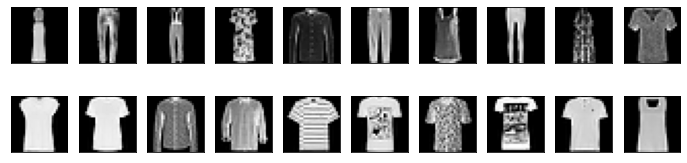

In [156]:
plt.figure(figsize=(12, 3))
viz_img(y_pred, 2)

## 2. PCA + K Means Clustering 

In [157]:
# 적절한 차원 수 찾아보기 
pca = PCA() 
pca.fit(X_train)

PCA(copy=True, iterated_power='auto', n_components=None, random_state=None,
    svd_solver='auto', tol=0.0, whiten=False)

In [158]:
cumsum = np.cumsum(pca.explained_variance_ratio_)
d = np.argmax(cumsum >= 0.95) + 1 ; d 

153

In [159]:
pca = decomposition.PCA(n_components=153).fit(X_train)
reduced_X = pca.transform(X_train)

In [160]:
kmeans = KMeans(init="k-means++", n_clusters=4, random_state=42)
kmeans.fit(reduced_X)
y_pred = kmeans.labels_

In [161]:
# confusion matrix 
pd.crosstab(y_pred, y_train, rownames=['Predicted'], colnames=['Actual'], margins=True)

Actual,0,1,3,6,All
Predicted,,,,,
0,143,5083,2798,43,8067
1,305,78,112,2517,3012
2,3538,232,1613,1100,6483
3,2014,607,1477,2340,6438
All,6000,6000,6000,6000,24000


In [162]:
# accuracy
cm = pd.crosstab(y_pred, y_train, rownames=['Predicted'], colnames=['Actual'], margins=True)
accuracy = (cm[0][0] + cm[1][1] + cm[3][2] + cm[6][3]) / 24000 ; accuracy

0.17391666666666666

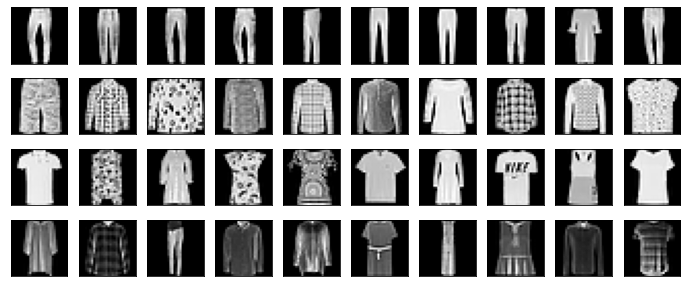

In [163]:
plt.figure(figsize=(12, 5))
viz_img(y_pred, 4)

## 3. Logistic Regression + K Means

In [185]:
log_reg = LogisticRegression(multi_class="ovr", solver="lbfgs", max_iter=5000, random_state=42)
log_reg.fit(X_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=5000,
                   multi_class='ovr', n_jobs=None, penalty='l2',
                   random_state=42, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [186]:
log_reg.score(X_test, y_test)

0.87225

In [187]:
pipeline = Pipeline([
                     ("kmeans", KMeans(n_clusters=16, random_state=42)),
                     ("log_reg", LogisticRegression(multi_class="ovr", solver="lbfgs", max_iter=5000, random_state=42)),
])

In [188]:
param_grid = dict(kmeans__n_clusters=range(2, 50))
grid_clf = GridSearchCV(pipeline, param_grid, cv=3, verbose=2)
grid_clf.fit(X_train, y_train)

Fitting 3 folds for each of 48 candidates, totalling 144 fits
[CV] kmeans__n_clusters=2 ............................................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] ............................. kmeans__n_clusters=2, total=   3.3s
[CV] kmeans__n_clusters=2 ............................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    3.4s remaining:    0.0s


[CV] ............................. kmeans__n_clusters=2, total=   3.7s
[CV] kmeans__n_clusters=2 ............................................
[CV] ............................. kmeans__n_clusters=2, total=   3.2s
[CV] kmeans__n_clusters=3 ............................................
[CV] ............................. kmeans__n_clusters=3, total=   4.1s
[CV] kmeans__n_clusters=3 ............................................
[CV] ............................. kmeans__n_clusters=3, total=   4.3s
[CV] kmeans__n_clusters=3 ............................................
[CV] ............................. kmeans__n_clusters=3, total=   4.1s
[CV] kmeans__n_clusters=4 ............................................
[CV] ............................. kmeans__n_clusters=4, total=   5.8s
[CV] kmeans__n_clusters=4 ............................................
[CV] ............................. kmeans__n_clusters=4, total=   5.1s
[CV] kmeans__n_clusters=4 ............................................
[CV] .

[Parallel(n_jobs=1)]: Done 144 out of 144 | elapsed: 61.8min finished


GridSearchCV(cv=3, error_score=nan,
             estimator=Pipeline(memory=None,
                                steps=[('kmeans',
                                        KMeans(algorithm='auto', copy_x=True,
                                               init='k-means++', max_iter=300,
                                               n_clusters=16, n_init=10,
                                               n_jobs=None,
                                               precompute_distances='auto',
                                               random_state=42, tol=0.0001,
                                               verbose=0)),
                                       ('log_reg',
                                        LogisticRegression(C=1.0,
                                                           class_weight=None,
                                                           dual=False,
                                                           fit_intercept=True,
                      

In [189]:
grid_clf.best_params_

{'kmeans__n_clusters': 48}

In [190]:
grid_clf.score(X_test, y_test)

0.85675

## 4. DBSCAN 
* tSNE + DBSCAN, eps 지정 등 여러 방법을 사용해 보았지만 군집이 잘 형성되지 않았습니다. 

In [182]:
dbscan = DBSCAN()
predict = dbscan.fit(X_train)
y_pred = predict.labels_

In [183]:
y_pred

array([-1, -1, -1, ..., -1, -1, -1])

In [184]:
len(dbscan.core_sample_indices_)

0

## 5. Gaussian Mixture

In [193]:
gm = GaussianMixture(n_components=4, n_init=10, random_state=42)
gm.fit(X_train)

GaussianMixture(covariance_type='full', init_params='kmeans', max_iter=100,
                means_init=None, n_components=4, n_init=10,
                precisions_init=None, random_state=42, reg_covar=1e-06,
                tol=0.001, verbose=0, verbose_interval=10, warm_start=False,
                weights_init=None)

In [194]:
gm.converged_

True

In [198]:
gm.score_samples(X_train)

array([1782.36235778, 1269.89716983, 1866.64256597, ...,  814.41605407,
       1790.92061076, 2915.68653077])

In [200]:
gm_y_pred = gm.predict(X_train)

In [202]:
# confusion matrix 
pd.crosstab(gm_y_pred, y_train, rownames=['Predicted'], colnames=['Actual'], margins=True)

Actual,0,1,3,6,All
Predicted,,,,,
0,191,5541,2575,59,8366
1,1138,46,102,1314,2600
2,489,42,220,2265,3016
3,4182,371,3103,2362,10018
All,6000,6000,6000,6000,24000


In [204]:
# accuracy
cm = pd.crosstab(gm_y_pred, y_train, rownames=['Predicted'], colnames=['Actual'], margins=True)
accuracy = (cm[0][0] + cm[1][1] + cm[3][2] + cm[6][3]) / 24000 ; accuracy

0.11745833333333333

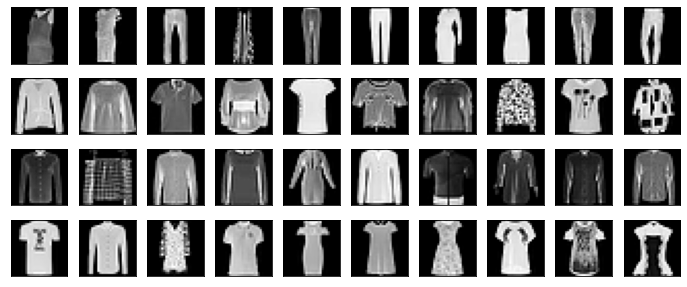

In [206]:
plt.figure(figsize=(12, 5))
viz_img(gm_y_pred, 4)

* 비슷한 특성끼리 잘 분류하고 있는 것 같습니다. 